<a href="https://colab.research.google.com/github/sarmadsaleem333/Play-with-Sentinel-Hub-API/blob/main/Play_SentinelHub_with_MSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Sentinel Hub Python

In [ ]:
!pip install sentinelhub

#Loading  ID and Credentials

In [ ]:

# add your keys here !!
id =""
secret=""


In [ ]:
from sentinelhub import SHConfig
config=SHConfig()
config.sh_client_id=id
config.sh_client_secret=secret

if not config.sh_client_id or not config.sh_client_secret:
  print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

#Libraries Import

In [ ]:
from sentinelhub import (
    CRS,BBox,
    DataCollection,DownloadRequest,MimeType,MosaickingOrder,SentinelHubDownloadClient,
    SentinelHubRequest, SentinelHubStatistical,
    bbox_to_dimensions,
)

# Defining Region of interest

In [ ]:
coords=(73.065215, 33.66584, 73.108465, 33.712503)
resolution =30
bbox=BBox(bbox=coords, crs=CRS.WGS84)
img_size=bbox_to_dimensions(bbox,resolution =resolution)


print(f'Image size at {resolution} m resolution: {img_size} pixels')

Image size at 30 m resolution: (137, 170) pixels


Single Data Satellite Image Acquisition

In [ ]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""



request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-10-18', '2023-11-18'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG),
    ],
    bbox=bbox,
    size=img_size,
    config=config
)

response = request.get_data()

In [ ]:
#plot the image
"""
Utilities used by example notebooks
"""

from __future__ import annotations

from typing import Any

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

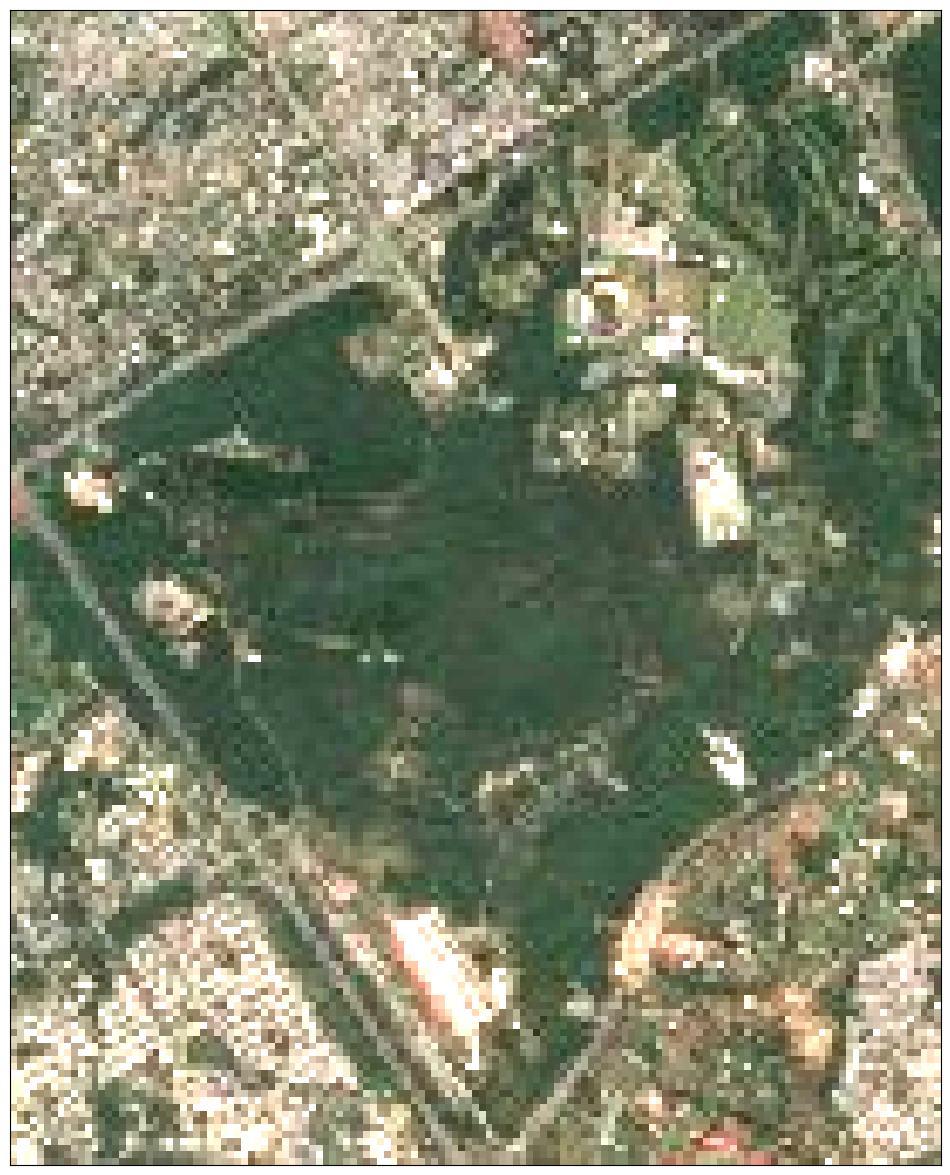

In [ ]:
plot_image(response[0],2.5/255,(0,1))

In [ ]:
response[0].shape

(170, 137, 3)

In [ ]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""



request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2024-10-18', '2024-11-18'),
            other_args={"dataFilter": {"maxCloudCoverage": 73,"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG),
    ],
    bbox=bbox,
    size=img_size,
    config=config
)

response = request.get_data()

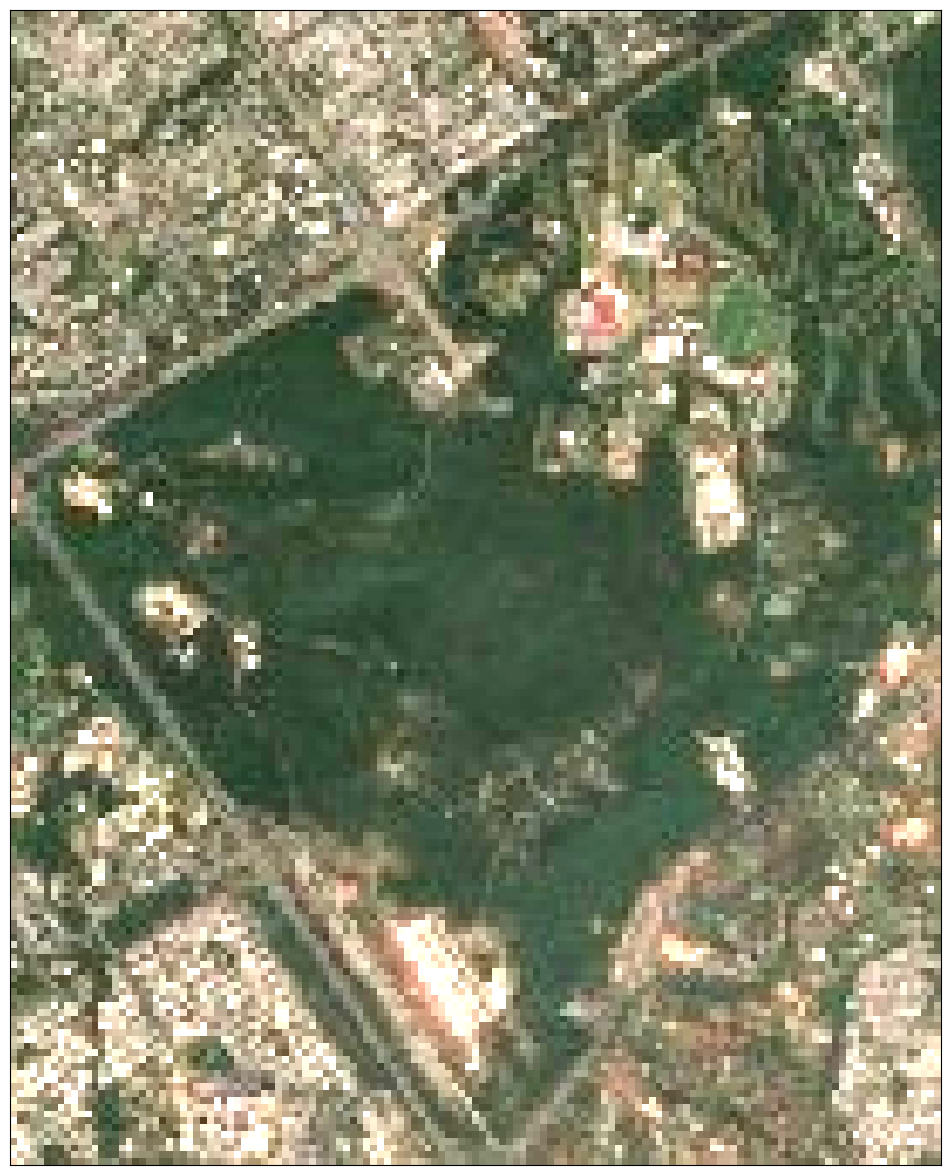

In [ ]:
plot_image(response[0],2.5/255,(0,1))

#Downloading satellite images from sentinel hub

Multiple Time Stamps

In [ ]:
import datetime

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')


In [ ]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

def get_true_color_request(time_interval):
    return SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2024-10-18', '2024-11-18'),
             other_args={"dataFilter": {"maxCloudCoverage": 73,"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=img_size,
    config=config
)



In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

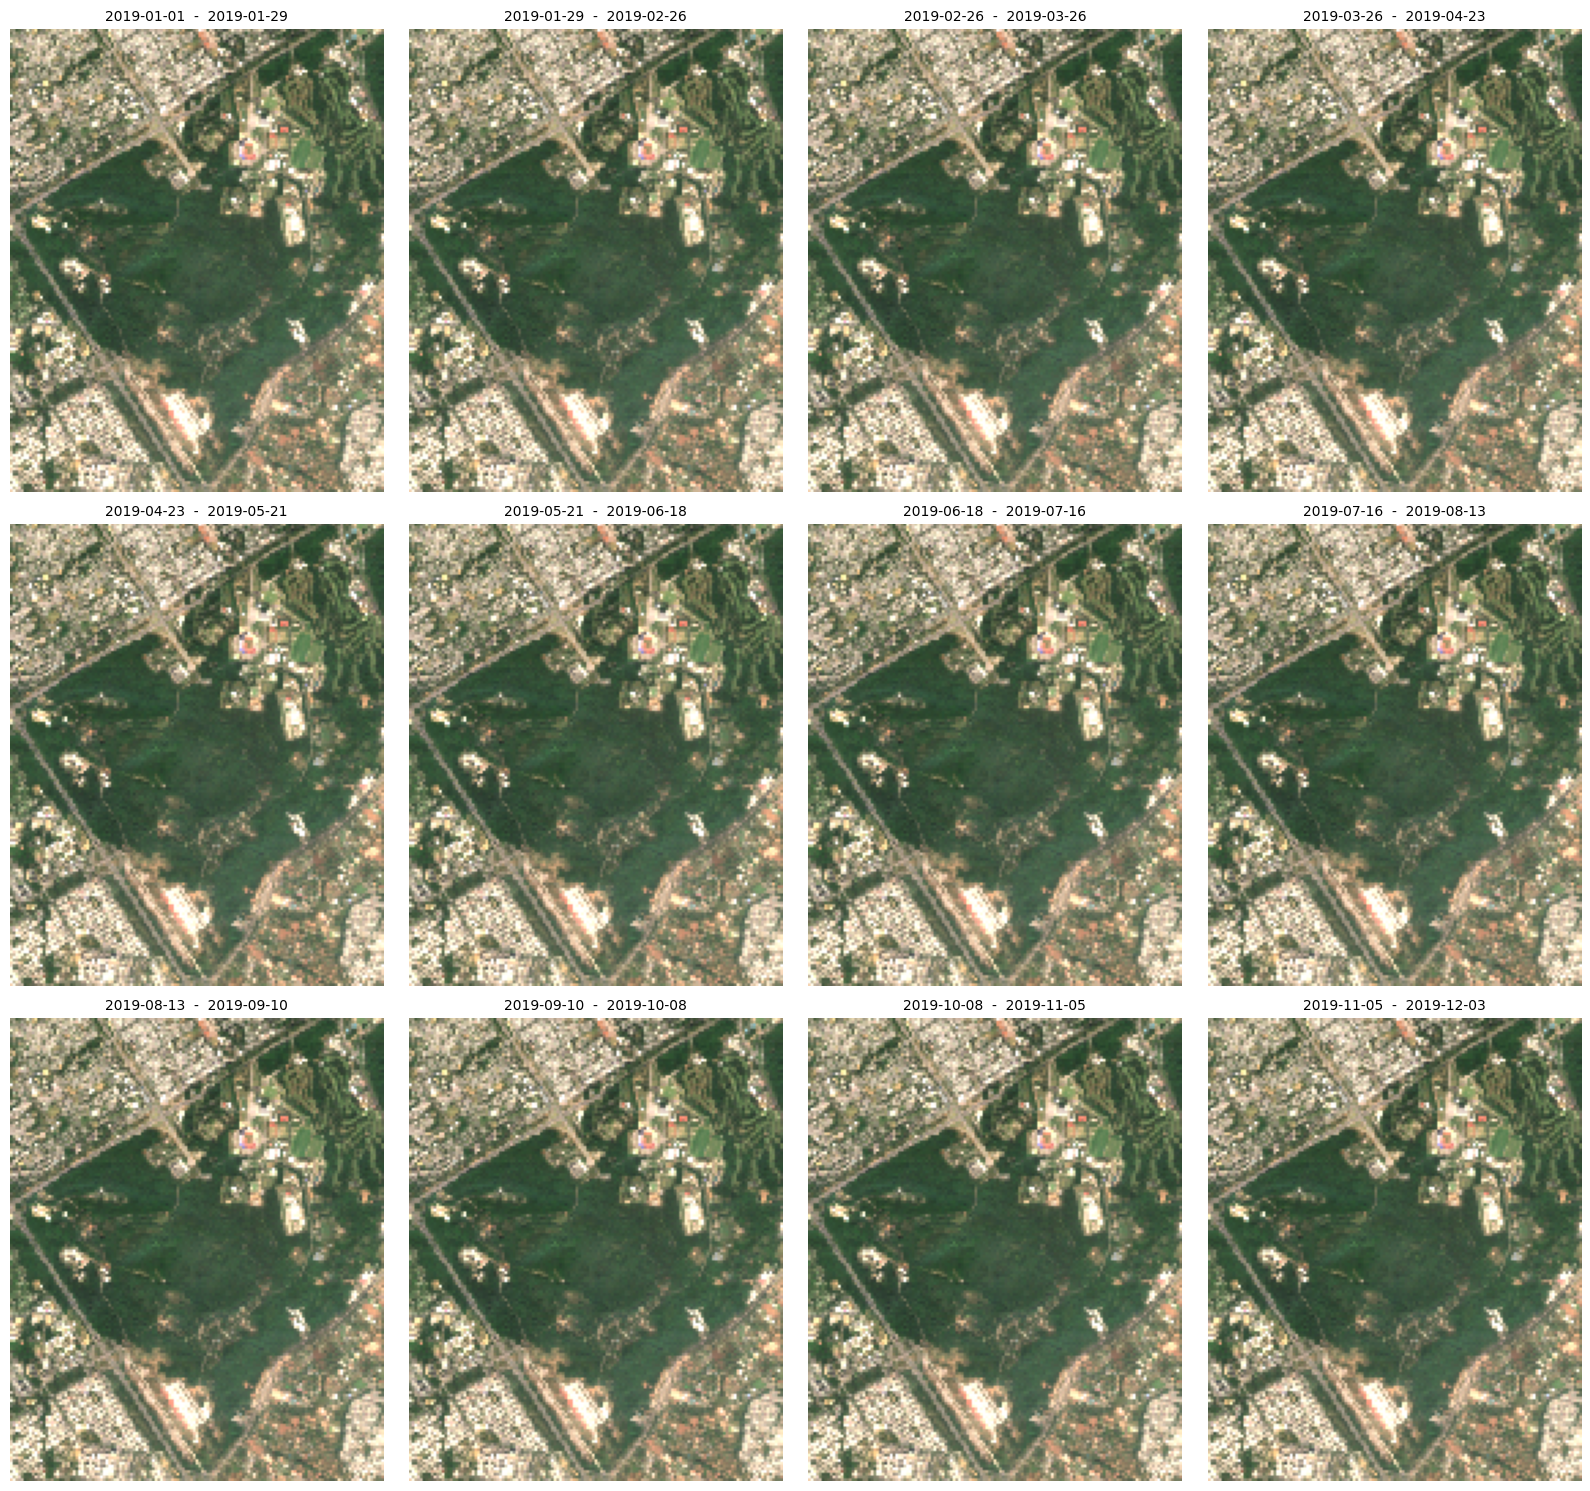

In [ ]:
# some stuff for pretty plots
import matplotlib.pyplot as plt
import numpy as np
ncols = 4
nrows = 3
aspect_ratio = img_size[0] / img_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()